# Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load Data and Rename Columns

In [2]:
file_path = '/Users/tamasbarczikay/VScode_projects/python-xgboost-clustering/Mall_Customers.csv'
data = pd.read_csv(file_path)

data = data.rename(columns={
    'CustomerID': 'id',
    'Gender': 'gender',
    'Age': 'age',
    'Annual Income (k$)': 'income',
    'Spending Score (1-100)': 'spending_score'
})

data_summary = pd.DataFrame({
    'Data Type': data.dtypes,
    'Missing Values': data.isnull().sum()
})

print(data_summary)

# Check and if exists drop duplicates
print(f"\nNumber of duplicate rows that were dropped: {data.duplicated().sum()}")
data = data.drop_duplicates()
print()

# Get statistical summary
print(data.describe().round(1))

               Data Type  Missing Values
id                 int64               0
gender            object               0
age                int64               0
income             int64               0
spending_score     int64               0

Number of duplicate rows that were dropped: 0

          id    age  income  spending_score
count  200.0  200.0   200.0           200.0
mean   100.5   38.8    60.6            50.2
std     57.9   14.0    26.3            25.8
min      1.0   18.0    15.0             1.0
25%     50.8   28.8    41.5            34.8
50%    100.5   36.0    61.5            50.0
75%    150.2   49.0    78.0            73.0
max    200.0   70.0   137.0            99.0


# EDA

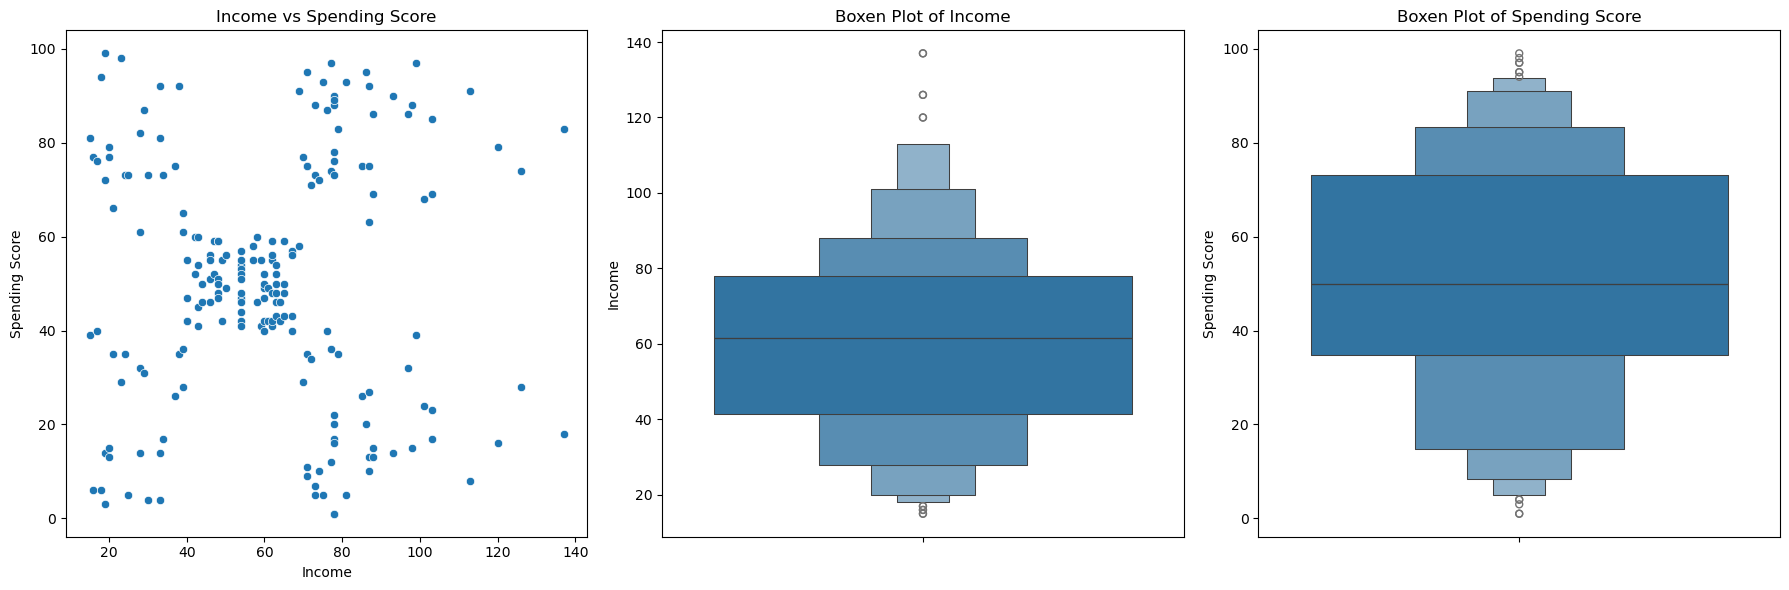

In [5]:
# Create 3 plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for income vs spending_score
sns.scatterplot(x=data['income'], y=data['spending_score'], ax=axes[0])
axes[0].set_title('Income vs Spending Score')
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Spending Score')

# Boxen plot for income
sns.boxenplot(y=data['income'], ax=axes[1])
axes[1].set_title('Boxen Plot of Income')
axes[1].set_ylabel('Income')

# Boxen plot for spending_score
sns.boxenplot(y=data['spending_score'], ax=axes[2])
axes[2].set_title('Boxen Plot of Spending Score')
axes[2].set_ylabel('Spending Score')

# Wrap ayout
plt.tight_layout()
plt.show()

In [6]:
# Drop id col, and select numeric vars to compute correlations
data = data.drop(columns=['id'])
numeric_data = data.select_dtypes(include=[np.number])

print(numeric_data.corr())

                     age    income  spending_score
age             1.000000 -0.012398       -0.327227
income         -0.012398  1.000000        0.009903
spending_score -0.327227  0.009903        1.000000


# KMEANS

Parameters to be set:

```Python
kmeans = KMeans(
    n_clusters=3,          # Number of clusters (k)
    init='k-means++',       # Method for initialization (random, k-means++, custom)
    max_iter=300,           # Maximum number of iterations for the algorithm
    tol=1e-4,               # Tolerance for convergence (default is 1e-4)
    n_init=10,              # Number of times the algorithm will run with different initializations
    random_state=42,        # Seed for reproducibility
    algorithm='auto',       # K-means algorithm to use (‘auto’, ‘full’, ‘elkan’)
    verbose=0               # Verbosity mode (0: silent, 1: detailed)
)
```

**`n_clusters`**

Predefine umber of clusters (k).

**`init`**

Initialization method:
- 'k-means++' (default): Selects initial cluster centers to speed up convergence.
- 'random': Chooses k observations randomly for the initial centroids.

**`max_iter`**

max_iter: Maximum number of iterations for a single run. Set between 300 and 500. Can be increased to 1000 if we have convergence issues.

**`tol`**

tol: Convergence tolerance. If the change in the cluster centers is smaller than tol, the algorithm stops. Common range between 1e-3 and 1e-6. 1e-3 runs slower, but smaller values give better estimate if the clusters are close.

**`n_init`**

n_init: Number of different initializations the algorithm will run to choose the best outcome. Range between 10 and 50. With higher cluster number it is wise to increase the value, since it improves cluster stability on the expense of longer computing time.

**`algorithm`**

Select algorithm to use:
'full': Uses the standard Lloyd K-means algorithm.
'elkan': Uses Elkan K-means variant, which is more efficient for high-dimensional data.

**`random_state`**

random_state: Controls the randomness of centroids initialization. I usually set to 42 for obvious geeky reasons.

**`verbose`**

verbose: Controls the verbosity during fitting. 0 gives no output, but increasing it prints out more granual data on the iteration process.

Silhouette Score for k=5: 0.4666

   Cluster Label  Count  Percentage Share
0              2    123              61.5
1              1     39              19.5
2              0     38              19.0


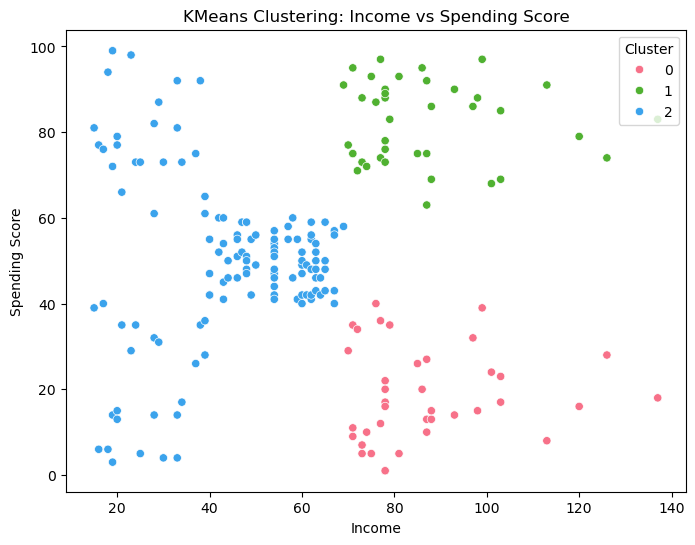

In [16]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['income', 'spending_score']])

# Perform KMeans with n=3 clusters
kmeans = KMeans(
    n_clusters=3,          # Preset number of clusters
    init='k-means++',      # Smart centroid initialization
    max_iter=500,          # Maximum iterations
    n_init=30,             # Number of times the algorithm will run
    random_state=42        # Seed for reproducibility
)
kmeans.fit(scaled_data)

# Add cluster labels to the data
data['cluster_id'] = kmeans.labels_

# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print(f"Silhouette Score for k=5: {silhouette_avg:.4f}")
print()

# Display cluster distribution
cluster_distribution = data['cluster_id'].value_counts().reset_index()
cluster_distribution.columns = ['Cluster Label', 'Count']
cluster_distribution['Percentage Share'] = 100 * cluster_distribution['Count'] / len(data)
print(cluster_distribution)

# Scatter plot to visualize the clusters
plt.figure(figsize=(8, 6))
unique_clusters = data['cluster_id'].unique()
palette = sns.color_palette('husl', len(unique_clusters))

sns.scatterplot(
    x=data['income'],
    y=data['spending_score'],
    hue=data['cluster_id'], 
    palette=palette,
    legend='full'
)

plt.title('KMeans Clustering: Income vs Spending Score')
plt.xlabel('Income')
plt.ylabel('Spending Score')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# KMEANS with Optimization and Elbow Plot


Optimization Results:
    k     inertia  silhouette_score
0   2  269.691012          0.321271
1   3  157.704008          0.466585
2   4  108.921317          0.493907
3   5   65.568408          0.554657
4   6   55.057348          0.539880
5   7   44.864756          0.528149
6   8   37.148117          0.456721
7   9   32.360230          0.456462
8  10   29.076177          0.449423

Optimal number of clusters based on silhouette_score: k = 5


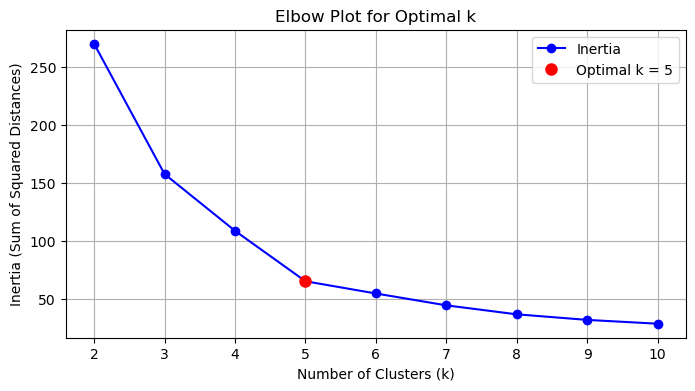


Silhouette Score for k=5: 0.5547

Cluster Distribution:
   Cluster Label  Count  Percentage Share
0              0     81              40.5
1              1     39              19.5
2              3     35              17.5
3              4     23              11.5
4              2     22              11.0


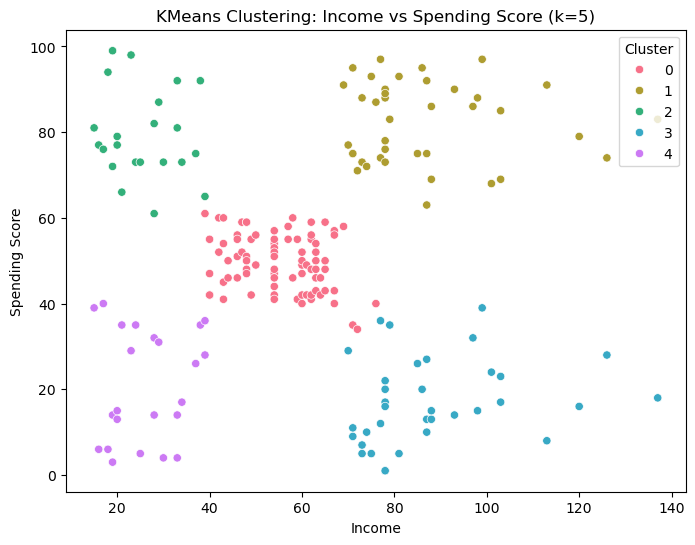

In [17]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['income', 'spending_score']])

# Set range for the number of clusters (from 2 to 10)
k_range = range(2, 11)
opt_metric = "silhouette_score"

# Store results
results = []

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,          # Number of clusters
        init='k-means++',      # Smart centroid initialization
        max_iter=500,          # Maximum iterations
        n_init=30,             # Number of times the algorithm will run
        random_state=42        # Seed for reproducibility
    )
    kmeans.fit(scaled_data)
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    results.append({
        'k': k,
        'inertia': kmeans.inertia_,          # Sum of squared distances (for elbow plot)
        'silhouette_score': silhouette_avg
    })

# Convert results to df
results_df = pd.DataFrame(results)

# Determine the optimal k based on silhouette score
best_k = results_df.loc[results_df['silhouette_score'].idxmax(), 'k']

# Print results and best k
print("\nOptimization Results:")
print(results_df)
print(f"\nOptimal number of clusters based on {opt_metric}: k = {best_k}")

# Elbow Plot with the optimal k marker
plt.figure(figsize=(8, 4))
plt.plot(results_df['k'], results_df['inertia'], 'bo-', label='Inertia')
plt.plot(
    best_k, 
    results_df.loc[results_df['k'] == best_k, 'inertia'].values[0], 
    'ro', markersize=8, label=f'Optimal k = {int(best_k)}'
)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Plot for Optimal k')
plt.legend()
plt.grid(True)
plt.show()

# Perform KMeans with optimal number of clusters
kmeans = KMeans(
    n_clusters=int(best_k), 
    init='k-means++', 
    max_iter=500, 
    n_init=30, 
    random_state=42
)
kmeans.fit(scaled_data)

# Add cluster labels to the data
data['cluster_id'] = kmeans.labels_

# Calculate and display silhouette score for the optimal k
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print(f"\nSilhouette Score for k={best_k}: {silhouette_avg:.4f}")

# Display cluster distribution
cluster_distribution = data['cluster_id'].value_counts().reset_index()
cluster_distribution.columns = ['Cluster Label', 'Count']
cluster_distribution['Percentage Share'] = 100 * cluster_distribution['Count'] / len(data)
print("\nCluster Distribution:")
print(cluster_distribution)

# Scatter plot to visualize clusters
plt.figure(figsize=(8, 6))
unique_clusters = data['cluster_id'].unique()
palette = sns.color_palette('husl', len(unique_clusters))

sns.scatterplot(
    x=data['income'],
    y=data['spending_score'],
    hue=data['cluster_id'], 
    palette=palette,
    legend='full'
)

plt.title(f'KMeans Clustering: Income vs Spending Score (k={best_k})')
plt.xlabel('Income')
plt.ylabel('Spending Score')
plt.legend(title='Cluster', loc='upper right')
plt.show()